In [1]:
using Plots
using LinearAlgebra
using FFTW

include("modulation.jl")
include("bits.jl")
include("ofdm.jl")
include("channel.jl")

Main.sisoChannel

In [2]:
# parameters
Nfft = 64    # number of ofdm subcarriers
Nblocks = 4  # number of ofdm blocks
Ncp = 15  # cyclix prefix length
Nsps = Nfft + Ncp # number of samples per block
Nsamples = Nsps*Nblocks # total number of time samples

# source modulation and codification parameters
modOrder = 64
bps = Int(log2(modOrder)) # bits per symbol
numBits = bps * Nfft * Nblocks
modulator = QAM(modOrder)

# SNR parameters
SNRdB = 20
SNRlin = 10^(SNRdB/10)
N0 = modulator.avgEb/SNRlin

# channel parameters
idxTapDelays = [1, 3, 5, 6, 10]
powTapDelaysdB = [0, -10, -15, -17, -19] # pdp
Ntaps = maximum(idxTapDelays)# number of channel taps

10

In [3]:
# generate payload data
bitstream = generateBitstream(numBits)
symstream = bitstream2symbolstream(bitstream, bps)
symstreamGray = [ encodeGray(s) for s in symstream ]
symbols = modulate(modulator, symstreamGray)
X = reshape(symbols, (Nfft, Nblocks))

64×4 Array{Complex{Int64},2}:
  3+7im  -1-7im  -1+7im  -1-3im
  7+5im   1+3im   3-7im  -7-3im
  5+5im   7+1im   5-3im   1-7im
  1-7im  -5-5im   7+3im  -3-1im
 -7-5im   5-1im   3+1im   5-3im
  3+1im  -5-5im  -1-1im   1-3im
 -5+1im   5-5im  -5-1im  -1-1im
 -1-1im   5-5im  -3+5im  -7+1im
 -1+7im   3+5im   5-5im  -1+5im
  5-7im   3-7im   7+7im  -5-1im
 -5-5im   1-3im   7-3im   5+7im
  5-1im   7-5im   1+1im   5+5im
 -7+5im   7+5im  -1-3im  -3+1im
   ⋮                     
 -5-7im  -3+7im   5-1im   1+3im
 -7-7im  -7-5im   3+3im   5-3im
  7-7im   5+5im   5+1im  -1-3im
 -5+1im   1+1im  -1-7im   3+5im
  1+7im  -1-7im   7+3im   3+7im
  3+1im   3-1im  -3+1im   3-7im
  3-3im  -7+1im   7-7im  -3-1im
 -3-1im   1+7im   5+1im   1+5im
 -3-7im   1+5im  -1-1im  -1+7im
 -5+5im  -1+1im   7-7im  -1+1im
 -7+3im  -7-3im   1-1im  -7-1im
 -1+5im  -7-3im  -7+7im  -1-3im

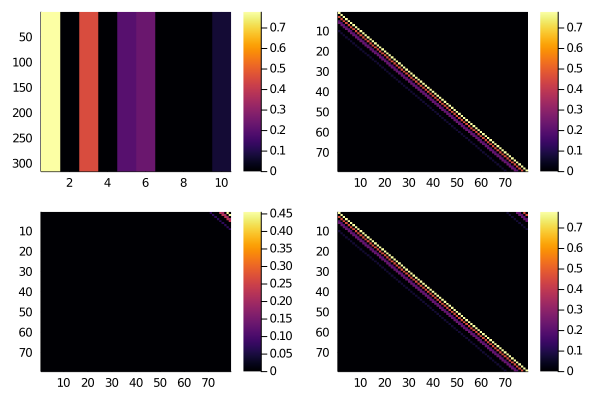

In [4]:
# generate channels
Hcir = sisoChannel.generateRayleighCIR(Nsamples, idxTapDelays, powTapDelaysdB)
Hcirc, Hisi = sisoChannel.generateCirculantChannelMatrix(Hcir, Nblocks, Nsps, Ntaps)

p0 = heatmap(abs.(Hcir), yflip=true)
p1 = heatmap(abs.(Hcirc[2,:,:]), yflip=true)
p2 = heatmap(abs.(Hisi[2,:,:]), yflip=true)
p3 = heatmap(abs.(Hcirc[2,:,:]+Hisi[2,:,:]), yflip=true)
plot(p0, p1, p2, p3, layout=4)

In [ ]:
# OFDM processing

param = ofdmSISO.Param(Nfft, Ncp, Nblocks)
Xcp = ofdmSISO.modulator(param, X)

Ycp = calculateChannelOutput(Xcp, Hcirc, Hisi, Nsps, Nblocks, N0)
Y = ofdmSISO.demodulator(param, Ycp)
Hest = ofdmSISO.formCSI(param, Hcirc)
Xest = ofdmSISO.equalizerOneTap(param, Hest, Y)

symbolsEst = vec(Xest)
symstreamEst = demodulate(modulator, symbolsEst)
symstreamEstGray = [ decodeGray(s) for s in symstreamEst ]
bitstreamEst = symbolstream2bitstream(symstreamEstGray, bps)

bitErrors = sum(bitstream .!= bitstreamEst)

ber = bitErrors/numBits

println(ber)

In [ ]:
effChan = Hest[3,:,:]

hf = Complex{Float32}.(diag(effChan))
ht = ifft(hf)

p0 = plot(10*log10.(abs.(hf)))
p1 = plot(abs.(ht).^2, line=:stem)
xlims!(0,32)

plot(p0, p1, layout=2)